# [Seq2Seq and Attention](https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html)

### Seq2Seq 한계

Seq2Seq 모델은 번역(translation), 챗봇 등의 task에서 높은 성능을 보였다. 하지만 Seq2Seq 모델은 커다란 한계가 있었다.

- 입력 시퀸스의 모든 정보를 하나의 고정된 크기의 벡터(컨텍스트 벡터)에 다 압축 요약하려 하다 보니 정보의 손실이 생길 수밖에 없다. 특히 시퀸스의 길이가 길다면 정보의 손실이 더 커진다.
- RNN 구조로 만들어진 모델이다 보니, 필연적으로 gradient vaninshing/exploding 현상이 발생한다.

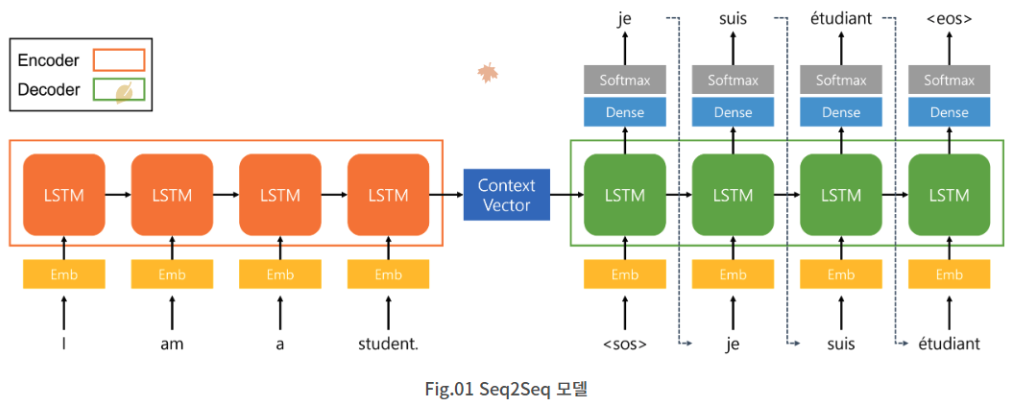

## [Attention Mechanism](https://wikidocs.net/22893)

어텐션 메커니즘은 Seq2Seq 모델의 문제점을 개선하기 위해 제안되었다.   

구체적으로, 어텐션 메커니즘은 다음을 가정한다.  
> 디코더가 단어 X를 출력하기 직전의 디코더 은닉 상태는 인코더가 입력 시퀀스에서 X와 연관이 깊은 단어를 읽은 직후의 인코더 은닉 상태와 유사할 것이다.   

예를 들어 영어 문장 "I am a student."을 한국어 문장 "나는 학생이다."로 번역하는 상황을 생각해 보자. 출력 시퀀스의 단어 "학생"은 입력 시퀀스의 단어 "I", "am", "a", "student", "." 중에서 "student"와 연관이 깊다.    
이때 `어텐션 메커니즘`은 디코더가 "학생"을 출력하기 직전의 은닉 상태는 인코더가 "student"를 입력받은 직후의 은닉 상태와 유사할 것이라고 가정한다.    
따라서 인코더가 "student"를 입력받은 직후의 은닉 상태에 조금 더 "집중"하면, 훨씬 더 품질 높은 번역을 만들 수 있을 것이다.

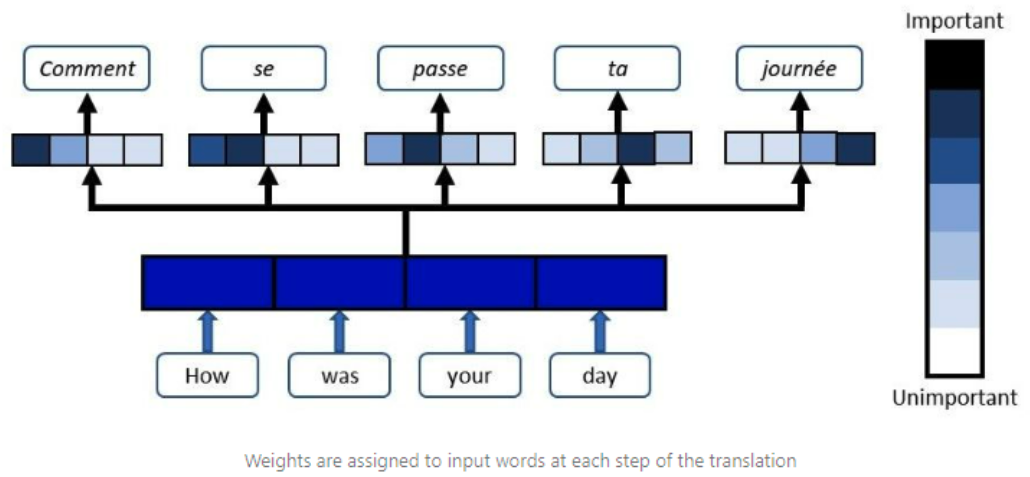

### Attention 동작 방법
- Q = Query : t 시점의 디코더 셀에서의 은닉 상태
- K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
- V = Values : 모든 시점의 인코더 셀의 은닉 상태들

1. 어텐션 스코어(유사도)를 구한다.
- 알고 싶은 Query(특정 output)의 hidden state가 각 Keys(input)들의 hidden state와 dot product를 계산하여 유사도를 구한다.

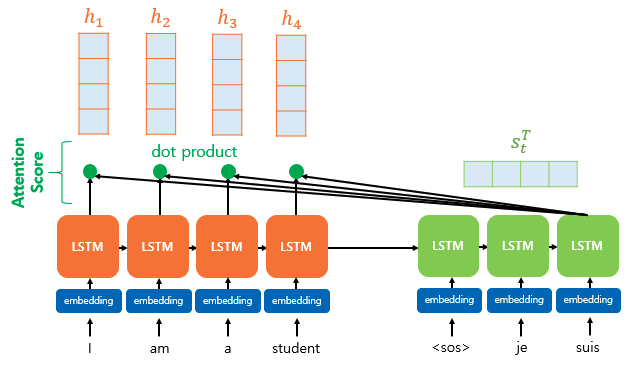

2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.
- 소프트맥스를 이용하여 어텐션 스코어의 확률 분포를 구한다. (즉, 유사도 가중치)

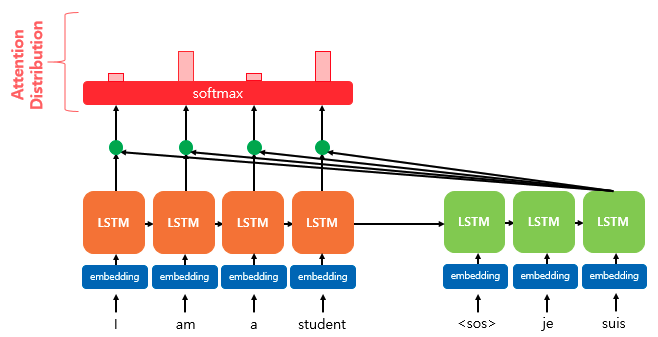

3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.
- 각 Keys(input)들의 hidden state와 유사도의 가중치들을 곱해서 어텐션 값을 구한다.
- 유사도의 가중치에 따라서 어텐션 값이 달라지게 되므로 해당 값을 통해서 어떤 input 데이터를 중요하게 생각해야 하는지를 알게되는 것이다.

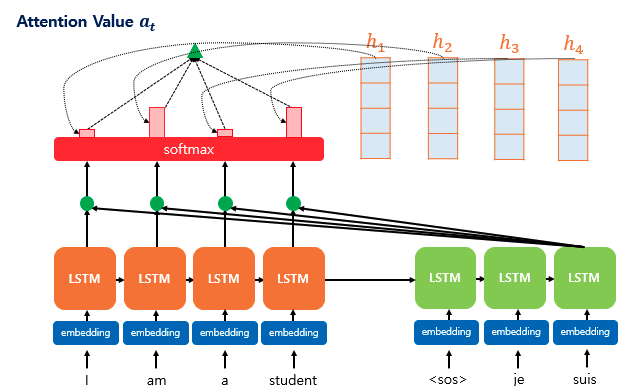

4. 어텐션 값과 디코더의 t시점의 은닉 상태를 연결한다. (concatenate)

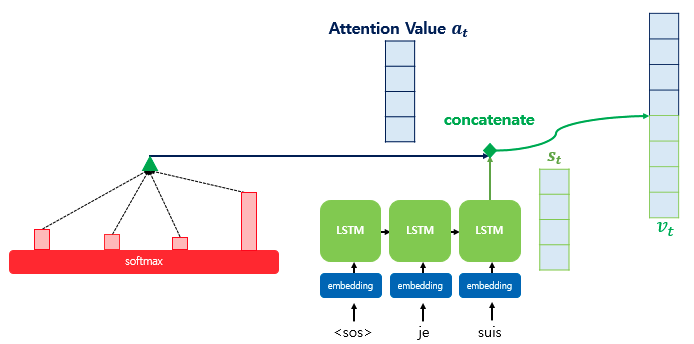

5. Dense layer와 softmax를 적용한다.

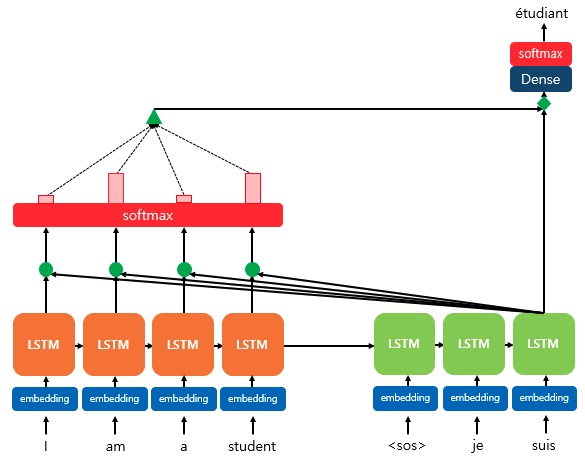

### 스코어 함수

query와 key 사이의 유사도를 구하는 함수를 스코어 함수라고 한다.   
아래 이미지는 유명한 스코어 함수들을 정리한 표이다.

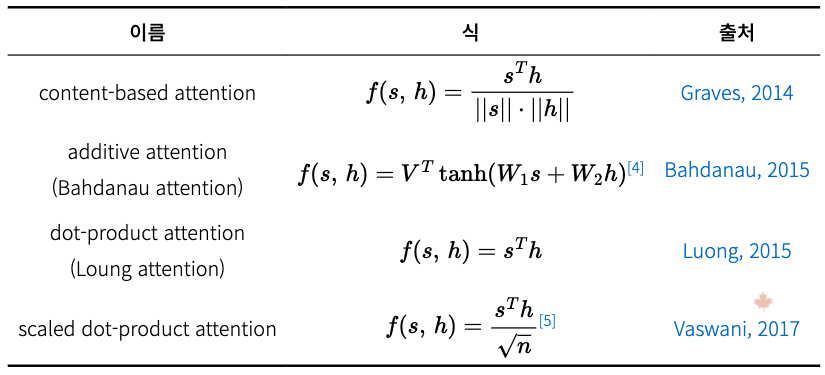

## Seq2Seq with Attention 동작 방법

1. 어느 시점의 인코더 은닉 상태에 조금 더 "집중"해야 하는지 찾기 위해, 현재 디코더의 은닉 상태와 매 시점 인코더의 은닉 상태들 간 "유사도"를 계산한다.  
2. 이 유사도를 확률의 형태로 바꾸고, 그 값에 따라 인코더 은닉 상태들의 가중합(weighted sum)을 구해 "보정된 컨텍스트 벡터"를 구한다.  
3. "보정된 컨텍스트 벡터"을 이용해 다음 단어를 예측한다.  

# [예제1](https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/4-2.Seq2Seq(Attention)/Seq2Seq(Attention).ipynb)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
n_step = 5 # number of cells(= number of Step)
n_hidden = 128 # number of hidden units in one cell

## 데이터

### 데이터 생성

In [3]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
len(sentences)

3

### 데이터 토큰화

In [4]:
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
len(word_list) # 총 단어의 수

11

### 데이터 사전

In [5]:
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list
n_class # 총 단어의 수

11

## Dataset

In [6]:
def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [7]:
input, output, target = make_batch()
input.shape, output.shape, target.shape # input: [batch_size, input_size, embedding_size(one-hot-encoding)]

<ipython-input-6-df2f7966fba9>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


(torch.Size([1, 5, 11]), torch.Size([1, 5, 11]), torch.Size([1, 5]))

## 모델

### 모델 생성

In [8]:
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.fc = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden # context vector
        n_step = len(dec_inputs)
        response = torch.empty([n_step, 1, n_class]) # 변역 결과를 저장할 응답 변수

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)

            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy()) # attn_weights 저장

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            attn_values = attn_weights.bmm(enc_outputs.transpose(0, 1)) # attn_values

            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]

            attn_values = attn_values.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            cat_output = torch.cat((dec_output, attn_values), 1)

            response[i] = self.fc(cat_output)

        # make response shape [n_step, n_class]
        return response.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

### 디버깅

In [9]:
input.shape, output.shape, target.shape # input: [batch_size, input_size, embedding_size(one-hot-encoding)]

(torch.Size([1, 5, 11]), torch.Size([1, 5, 11]), torch.Size([1, 5]))

In [10]:
n_class, n_hidden

(11, 128)

In [11]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

attn = nn.Linear(n_hidden, n_hidden)
out = nn.Linear(n_hidden * 2, n_class)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
hidden = torch.zeros(1, 1, n_hidden)
hidden.shape # hidden: [direction(1) * layer(1), batch_size, hidden_size]

torch.Size([1, 1, 128])

In [13]:
# input, output, target
enc_inputs = input.transpose(0, 1)
dec_inputs = output.transpose(0, 1)

enc_inputs.shape, dec_inputs.shape # enc_inputs: [input_size, batch_size, embedding_size(one-hot-encoding)]

(torch.Size([5, 1, 11]), torch.Size([5, 1, 11]))

- 인코딩
  - output: (input_size, batch_size, hidden_size * directions)
  - hidden: (layers * directions, batch_size, hidden_size)
  > 인코딩의 hidden은 context vector를 나타냄

In [14]:
enc_outputs, enc_hidden = enc_cell(enc_inputs, hidden)

enc_outputs.shape, enc_hidden.shape

(torch.Size([5, 1, 128]), torch.Size([1, 1, 128]))

- 디코딩 초기값 정의

In [15]:
trained_attn = []
context_vector = enc_hidden # context vector
n_step = len(dec_inputs)

context_vector.shape, n_step # n_step: input_size

(torch.Size([1, 1, 128]), 5)

In [16]:
response = torch.empty([n_step, 1, n_class])
response.shape # response: [word_size, batch_size, total_word_size] -> 번역 결과를 저장할 변수

torch.Size([5, 1, 11])

- 첫번째 단어에 대한 디코딩

In [17]:
dec_inputs.shape # [input_size, batch_size, embedding_size(one-hot-encoding)]

torch.Size([5, 1, 11])

In [18]:
dec_inputs[0].shape # 첫번째 단어 dec_inputs[0]: [batch_size, embedding_size(one-hot-encoding)]

torch.Size([1, 11])

In [19]:
one_dec_input = dec_inputs[0].unsqueeze(0) # 인풋차원 추가 dec_inputs[0]: [input_size, batch_size, embedding_size(one-hot-encoding)]
one_dec_input.shape

torch.Size([1, 1, 11])

In [20]:
context_vector.shape # context_vector(hidden): [direction(1) * layer(1), batch_size, hidden_size]

torch.Size([1, 1, 128])

- 디코딩
  - output: (input_size, batch_size, embedding_size * directions)
  - hidden: (layers * directions, batch_size, embedding_size)

In [21]:
one_dec_output, hidden = dec_cell(one_dec_input, context_vector)

one_dec_output.shape, hidden.shape

(torch.Size([1, 1, 128]), torch.Size([1, 1, 128]))

- 어텐션 스코어

In [22]:
# enc_outputs(5개의 단어) (input_size, batch_size, embedding_size * directions)
# one_dec_output(1개의 단어) (input_size, batch_size, embedding_size * directions)
enc_outputs.shape, one_dec_output.shape

(torch.Size([5, 1, 128]), torch.Size([1, 1, 128]))

첫번째 인풋 데이터에 대한 어텐션 스코어 연산

In [23]:
def get_att_score(one_dec_output, one_enc_output):  # one_enc_output [batch_size, num_directions(=1) * n_hidden]
  score = attn(one_enc_output)  # score : [batch_size, n_hidden]
  return torch.dot(one_dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [24]:
attn

Linear(in_features=128, out_features=128, bias=True)

In [25]:
score = attn(enc_outputs[0])
score.shape

torch.Size([1, 128])

In [26]:
one_dec_output.view(-1).shape, score.view(-1).shape

(torch.Size([128]), torch.Size([128]))

In [27]:
torch.dot(one_dec_output.view(-1), score.view(-1))

tensor(0.1118, grad_fn=<DotBackward0>)

- 어텐션 확률값 생성
  - 쿼리(특정 단어)에 대한 각 인풋 단어들의 어텐션 확률값(0~1) 생성
  > 쿼리에 대한 인풋 단어들의 유사도(어텐션)값 확인

In [28]:
def get_att_weight(dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
  n_step = len(enc_outputs) # n_step: input_size
  attn_scores = torch.zeros(n_step)  # attn_scores : 단어별 attn score를 저장할 변수

  for i in range(n_step):
      attn_scores[i] = get_att_score(dec_output, enc_outputs[i]) # 단어별 atten score 저장

  # Normalize scores to weights in range 0 to 1
  return F.softmax(attn_scores).view(1, 1, -1) # atten value 리턴

In [29]:
# one_dec_output: [input_size(one word), batch_size, hidden_size], enc_outputs: [input_size, batch_size, hidden_size]
one_dec_output.shape, enc_outputs.shape

(torch.Size([1, 1, 128]), torch.Size([5, 1, 128]))

In [30]:
attn_weights = get_att_weight(one_dec_output, enc_outputs)
attn_weights.shape # attn_weights: [batch_size, atten_weight_size, input_size]

<ipython-input-28-c426a1e7278b>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1) # atten value 리턴


torch.Size([1, 1, 5])

In [31]:
attn_weights.squeeze() # attn_weights.squeeze(): 단어별 확률값

tensor([0.1880, 0.2067, 0.1922, 0.2059, 0.2072], grad_fn=<SqueezeBackward0>)

In [32]:
attn_weights.squeeze().sum() # 전체 확률값의 합은 1

tensor(1.0000, grad_fn=<SumBackward0>)

- 어텐션 value값 생성
  - 어텐션 확률값 * 인코딩 데이터

In [33]:
enc_outputs.shape

torch.Size([5, 1, 128])

In [34]:
# enc_outputs.transpose(0, 1): [batch_size, input_size, hidden_size]
attn_values = attn_weights.bmm(enc_outputs.transpose(0, 1)) # bmm(곱셈): attn_weights * enc_outputs
attn_values.shape # attn_values: [batch_size, atten_weight_size, hidden_size]

torch.Size([1, 1, 128])

In [35]:
one_dec_output.shape # [input_size, batch_size, hidden_size]

torch.Size([1, 1, 128])

In [36]:
dec_output = one_dec_output.squeeze(0)
dec_output.shape # [batch_size, hidden_size]

torch.Size([1, 128])

In [37]:
attn_values = attn_values.squeeze(1)
attn_values.shape # [batch_size, hidden_size]

torch.Size([1, 128])

In [38]:
output_cat = torch.cat((dec_output, attn_values), 1)
output_cat.shape # [batch_size, (hidden_size + hidden_size)]

torch.Size([1, 256])

In [39]:
out_linear = nn.Linear(n_hidden * 2, n_class)

In [40]:
out = out_linear(output_cat)
out.shape # 전체 단어중 가장 알맞은 단어 리턴

torch.Size([1, 11])

In [41]:
response.shape

torch.Size([5, 1, 11])

In [42]:
response[0] = out # 첫번째 알맞은 단어 리턴

## 학습

In [43]:
# hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
hidden = torch.zeros(1, 1, n_hidden)

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

# Train
for epoch in range(2000):

    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<ipython-input-8-7712861b8b95>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


Epoch: 0400 cost = 0.000483
Epoch: 0800 cost = 0.000155
Epoch: 1200 cost = 0.000076
Epoch: 1600 cost = 0.000045
Epoch: 2000 cost = 0.000029


## 평가

In [44]:
# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
test_batch = torch.FloatTensor(test_batch)
predict, trained_attn = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


<ipython-input-8-7712861b8b95>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


<ipython-input-45-4de4c42c3437>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
<ipython-input-45-4de4c42c3437>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


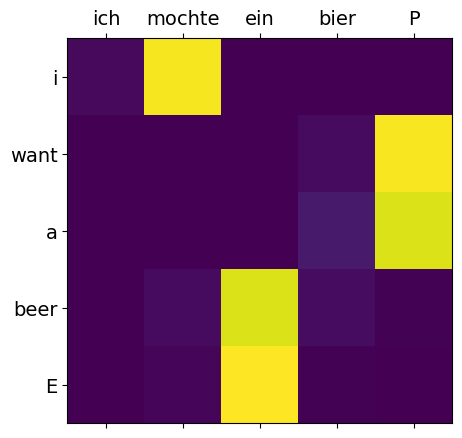

In [45]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()

# 예제2(영어->한글)

In [46]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

In [47]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [48]:
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [50]:
from google.colab import drive

drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"


Mounted at /content/drive


In [51]:
train = pd.read_csv(f"{DATA_PATH}translate_en_ko.csv")

print(train.shape)
train.head()

(5794, 2)


,en,ko
0,These products are of the same quality.,이 제품들은 같은 품질이다.
1,The meeting was cancelled.,미팅이 취소되었다.
2,They found this.,그들이 이것을 찾았다.
3,Tom didn't tell Mary why he had to work late.,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.
4,After you.,먼저 가세요.


## Text Preprocessing

### Cleaning

In [52]:
train["en"] = train["en"].str.replace("[^a-zA-Z0-9 .,!?\'\"]" , "",regex=True).str.lower()
train["ko"] = train["ko"].str.replace("[^가-힣0-9 .,!?\'\"]" , "",regex=True)

In [53]:
train.head()

,en,ko
0,these products are of the same quality.,이 제품들은 같은 품질이다.
1,the meeting was cancelled.,미팅이 취소되었다.
2,they found this.,그들이 이것을 찾았다.
3,tom didn't tell mary why he had to work late.,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.
4,after you.,먼저 가세요.


### 토큰 & 어휘집

In [54]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=e2ee0a0231c9ed42863076c2b6cf85c6a4a9b0fb42127b6a0c77f05c8ae56509
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


#### 한글

In [55]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [56]:
result = kiwi.tokenize(train["ko"])

src_data = []
for tokens in result:
    tokens = [ t.form for t in tokens]
    src_data.append(tokens)

In [57]:
from torchtext.vocab import build_vocab_from_iterator

vocab_ko = build_vocab_from_iterator(src_data,specials=["<pad>","<unk>"])
vocab_ko.set_default_index(vocab_ko["<unk>"])
len(vocab_ko)

3245

In [58]:
src_data = [ vocab_ko(tokens) for tokens in src_data ]
src_data[0]

[4, 2926, 32, 8, 50, 8, 3151, 4, 9, 2]

#### 영어

In [59]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

In [60]:
sos_token = "<sos>"
eos_token = "<eos>"

In [61]:
tgt_data = []
for text in train["en"]:
    tokens = [sos_token] + tokenizer(text) + [eos_token]
    tgt_data.append(tokens)

In [62]:
from torchtext.vocab import build_vocab_from_iterator

vocab_en = build_vocab_from_iterator(tgt_data,specials=["<pad>","<unk>",sos_token,eos_token])
vocab_en.set_default_index(vocab_en["<unk>"])
len(vocab_en)

3129

In [63]:
tgt_data = [ vocab_en(tokens) for tokens in tgt_data]

## Dataset

In [64]:
from torch.utils.data import Dataset

In [65]:
class TranslateDataset(Dataset):
    def __init__(self,src,tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self,idx):
        item = {}
        item["src"] = torch.tensor(self.src[idx])
        item["tgt"] = torch.tensor(self.tgt[idx])
        return item

In [66]:
dt = TranslateDataset(src_data,tgt_data)
len(dt)

5794

In [67]:
dt[0]

{'src': tensor([   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2]),
 'tgt': tensor([   2,  210, 2696,   29,   27,   11,  291, 1584,    4,    3])}

### collate_fn

- torch.nn.utils.rnn.pad_sequence
    - 첫번째 인수로 정수번호로 이루어진 1차원 텐서들을 담은 리스트 전달
    - 리스트 안의 텐서에 최대 길이에 맞춰 패딩해줘서 텐서로 반환
    - batch_first = True 주면 batch 차원을 앞에다가 넣어서 전달해도 된다.

In [68]:
def collate_fn(samples):
    # print(samples)
    src = [ sample["src"] for sample in samples ]
    tgt = [ sample["tgt"] for sample in samples ]

    src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)
    tgt = torch.nn.utils.rnn.pad_sequence(tgt, batch_first=True)
    return {"src":src, "tgt":tgt }

## DataLoader

In [69]:
from torch.utils.data import DataLoader

In [70]:
dl = DataLoader(dt,batch_size=2,shuffle=False,collate_fn=collate_fn)
batch = next(iter(dl))
batch

{'src': tensor([[   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2],
         [1112,    4, 1255,   38,    6,    9,    2,    0,    0,    0]]),
 'tgt': tensor([[   2,  210, 2696,   29,   27,   11,  291, 1584,    4,    3],
         [   2,   11,  574,   23, 1314,    4,    3,    0,    0,    0]])}

## Model

### Encoder

In [73]:
class Encoder(torch.nn.Module):
    def __init__(self,num_embeddings, embedding_dim):
        super().__init__()
        self.emb_layer =torch.nn.Embedding(num_embeddings, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*2, batch_first=True,bidirectional=True)
    def forward(self,x):
        x = self.emb_layer(x)
        outputs, (hn,cn) = self.rnn_layer(x)
        return outputs, hn,cn

In [74]:
encoder = Encoder(len(vocab_ko),64)
outputs, hn,cn = encoder(batch["src"])
outputs.shape, hn.shape ,cn.shape

(torch.Size([2, 10, 256]), torch.Size([2, 2, 128]), torch.Size([2, 2, 128]))

### Decoder

In [75]:
class Decoder(torch.nn.Module):
    def __init__(self,num_embeddings, embedding_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(num_embeddings,embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim,embedding_dim*4,batch_first=True)
        self.attn_key_layer = torch.nn.Linear(embedding_dim*4,embedding_dim*4)

        self.fc_layer = torch.nn.Linear(embedding_dim*8,num_embeddings)
    def forward(self,x,enc_outputs,hn,cn):
        x = self.emb_layer(x) # batch, 1 , features

        hn = hn.permute(1,0,2).flatten(1).unsqueeze(0)
        cn = cn.permute(1,0,2).flatten(1).unsqueeze(0)

        outputs, (hn,cn) = self.rnn_layer(x , (hn,cn))

        # query , key 정의
        attn_key = self.attn_key_layer(enc_outputs) # keys (batch,seq,feautre)
        attn_key = attn_key.permute(1,0,2).flatten(1) # ( seq, batch+feature )
        attn_query = hn[-1].view(-1).unsqueeze(dim=1) # (batch+feature , 1 )

        # 어텐션 스코어 구하기
        attn_scores = torch.matmul(attn_key,attn_query) # (seq, 1)
        attn_scores = torch.nn.functional.softmax(attn_scores,dim=0) # 어텐션 분포 (seq, 1)
        attn_scores = attn_scores.view(1,1,-1) # (1, 1, seq)
        attn_scores = attn_scores.repeat(enc_outputs.shape[0],1,1) # batch, 1 , seq
        # enc_outputs(batch,seq,feautre)

        # 어텐션 벨류 구하기
        attn_values = torch.bmm(attn_scores , enc_outputs)  # batch, 1 ,feautre

        # hn -> nlayer, batch,feature
        # attn_values -> batch, 1 ,feautre
        x = torch.cat([ hn[-1], attn_values[:,-1] ], dim=1)
        prediction = self.fc_layer(x)
        return prediction, hn,cn

In [76]:
batch["tgt"][:,:1].shape

torch.Size([2, 1])

In [77]:
decoder = Decoder(len(vocab_en), 64)
prediction, hn,cn = decoder(batch["tgt"][:,:1], outputs, hn,cn)
prediction.shape

torch.Size([2, 3129])

### Seq2Seq with Attention Model

In [78]:
class Net(torch.nn.Module):
    def __init__(self,vocab_size_src,vocab_size_tgt,embedding_dim = 64, device = "cpu"):
        super().__init__()
        self.encoder = Encoder(vocab_size_src,embedding_dim)
        self.decoder = Decoder(vocab_size_tgt,embedding_dim)

        self.vocab_size_tgt = vocab_size_tgt
        self.device = device

    def forward(self,src,tgt,enc_outputs=None,hn=None,cn=None, teacher_forcing_ratio = 0.5):

        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        pred = torch.zeros(batch_size,tgt_len,self.vocab_size_tgt).to(self.device)

        if enc_outputs is None:
            enc_outputs, hn,cn = self.encoder(src)

        dec_input = tgt[:,0].view(-1,1)
        for t in range(1,tgt_len):
            output, hn,cn = self.decoder(dec_input,enc_outputs, hn,cn)

            pred[:,t] = output
            dec_input = output.argmax(1).view(-1,1)

            if random.random() < teacher_forcing_ratio:
                dec_input = tgt[:,t].view(-1,1)

        return pred, enc_outputs ,hn,cn

In [79]:
model = Net(len(vocab_ko), len(vocab_en))
pred , _ , _, _ = model(batch["src"],batch["tgt"])
pred.shape

torch.Size([2, 10, 3129])

## Engine

In [80]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in tqdm(dataloader):
        src = batch["src"].to(device)
        tgt = batch["tgt"].to(device)
        pred, _ , _ ,_ = model(src,tgt)
        n_class = pred.shape[-1]
        pred = pred.view(-1,n_class)# s , 단어별 예측값
        tgt = tgt.flatten() # 정답데이터는 벡터형태로

        mask = tgt > 2
        tgt = tgt[mask]
        pred = pred[mask]
        loss = loss_fn(pred, tgt)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    return epoch_loss

## Training

In [81]:
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 50

In [82]:
reset_seeds(SEED)

model = Net(len(vocab_ko), len(vocab_en),device=device).to(device)
optimizer = torch.optim.Adam(model.parameters())

train_dt = TranslateDataset(src_data,tgt_data)
train_dl = torch.utils.data.DataLoader(train_dt,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

for _ in range(epochs):
    train_loss = train_loop(train_dl,model,loss_fn,optimizer,device)
    print(train_loss)

  0%|          | 0/91 [00:00<?, ?it/s]

5.3516633693988505


  0%|          | 0/91 [00:00<?, ?it/s]

4.3534880339444335


  0%|          | 0/91 [00:00<?, ?it/s]

3.945385293646173


  0%|          | 0/91 [00:00<?, ?it/s]

3.5851074234469906


  0%|          | 0/91 [00:00<?, ?it/s]

3.241023123919309


  0%|          | 0/91 [00:00<?, ?it/s]

2.910309977583833


  0%|          | 0/91 [00:00<?, ?it/s]

2.6249805230360765


  0%|          | 0/91 [00:00<?, ?it/s]

2.3841656158258626


  0%|          | 0/91 [00:00<?, ?it/s]

2.1582930192842587


  0%|          | 0/91 [00:00<?, ?it/s]

1.974935580085922


  0%|          | 0/91 [00:00<?, ?it/s]

1.8002878453705338


  0%|          | 0/91 [00:00<?, ?it/s]

1.6330958290414497


  0%|          | 0/91 [00:00<?, ?it/s]

1.5100642652301999


  0%|          | 0/91 [00:00<?, ?it/s]

1.3620912059322818


  0%|          | 0/91 [00:00<?, ?it/s]

1.2107387230946467


  0%|          | 0/91 [00:00<?, ?it/s]

1.138749625656631


  0%|          | 0/91 [00:00<?, ?it/s]

1.0173126937268855


  0%|          | 0/91 [00:00<?, ?it/s]

0.9513742858236962


  0%|          | 0/91 [00:00<?, ?it/s]

0.8656826425384689


  0%|          | 0/91 [00:00<?, ?it/s]

0.7830649083787269


  0%|          | 0/91 [00:00<?, ?it/s]

0.683105788060597


  0%|          | 0/91 [00:00<?, ?it/s]

0.6137964620695009


  0%|          | 0/91 [00:00<?, ?it/s]

0.553782269849882


  0%|          | 0/91 [00:00<?, ?it/s]

0.48834052485424084


  0%|          | 0/91 [00:00<?, ?it/s]

0.4295266814284272


  0%|          | 0/91 [00:00<?, ?it/s]

0.3839118623144024


  0%|          | 0/91 [00:00<?, ?it/s]

0.33304941686955125


  0%|          | 0/91 [00:00<?, ?it/s]

0.29372108621256693


  0%|          | 0/91 [00:00<?, ?it/s]

0.2568197217616406


  0%|          | 0/91 [00:00<?, ?it/s]

0.22950927651190495


  0%|          | 0/91 [00:00<?, ?it/s]

0.21480788519749275


  0%|          | 0/91 [00:00<?, ?it/s]

0.18333682589806044


  0%|          | 0/91 [00:00<?, ?it/s]

0.17055009002541446


  0%|          | 0/91 [00:00<?, ?it/s]

0.14731459794463692


  0%|          | 0/91 [00:00<?, ?it/s]

0.13833864761905357


  0%|          | 0/91 [00:00<?, ?it/s]

0.12497817544819234


  0%|          | 0/91 [00:00<?, ?it/s]

0.11734941069568906


  0%|          | 0/91 [00:00<?, ?it/s]

0.11481923323411208


  0%|          | 0/91 [00:00<?, ?it/s]

0.10846926427477009


  0%|          | 0/91 [00:00<?, ?it/s]

0.09837583902772966


  0%|          | 0/91 [00:00<?, ?it/s]

0.09146439275898777


  0%|          | 0/91 [00:00<?, ?it/s]

0.09270321053790521


  0%|          | 0/91 [00:00<?, ?it/s]

0.0912045962535418


  0%|          | 0/91 [00:00<?, ?it/s]

0.08288976492790076


  0%|          | 0/91 [00:00<?, ?it/s]

0.07638940767763736


  0%|          | 0/91 [00:00<?, ?it/s]

0.07727233615222869


  0%|          | 0/91 [00:00<?, ?it/s]

0.07351374396911034


  0%|          | 0/91 [00:00<?, ?it/s]

0.07665063784672664


  0%|          | 0/91 [00:00<?, ?it/s]

0.07423467013043361


  0%|          | 0/91 [00:00<?, ?it/s]

0.07258205017545721


## Prediction

In [83]:
tgt_max_len = max( len(lst) for lst in tgt_data)
tgt_max_len

112

In [84]:
@torch.no_grad()
def translate(text,model,vocab_src,vocab_tgt,tgt_max_len,device):
    model.eval()
    src = vocab_src([ t.form for t in kiwi.tokenize(text) ])
    src = torch.tensor(src).view(1,-1).to(device)

    tgt = [2,0] # sos 토큰과 패딩토큰을 넣어서 디코더가 한번 반복 되게하기!!
    tgt = torch.tensor(tgt).view(1,-1).to(device)

    enc_outputs = None
    hn = None
    cn = None
    for _ in range(tgt_max_len):
        pred,enc_outputs , hn, cn = model(src,tgt,enc_outputs,hn,cn)
        char_no = pred[-1,-1].argmax().item()

        if char_no == 3:
            break

        print(vocab_tgt.lookup_token(char_no), end=" ")
        tgt = [char_no,0]
        tgt = torch.tensor(tgt).view(1,-1).to(device)

In [85]:
n = 0
text = train["ko"][n]
print(train["en"][n])
text

these products are of the same quality.


'이 제품들은 같은 품질이다.'

In [86]:
translate(text,model,vocab_ko,vocab_en,tgt_max_len,device)

the products are of the same to me . 